# 4. Сверточные нейронные сети.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [38]:
from pathlib import Path
import typing as t

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import seaborn as sns
from sklearn import metrics
from collections import OrderedDict

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("data/")
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR = Path("models/")
MODELS_DIR.mkdir(exist_ok=True)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cpu device


## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [6]:
_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
).data.to(torch.float32)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
])

train_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

train_data.data.size(), train_data.targets.size(), len(train_data.classes)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(torch.Size([60000, 28, 28]), torch.Size([60000]), 10)

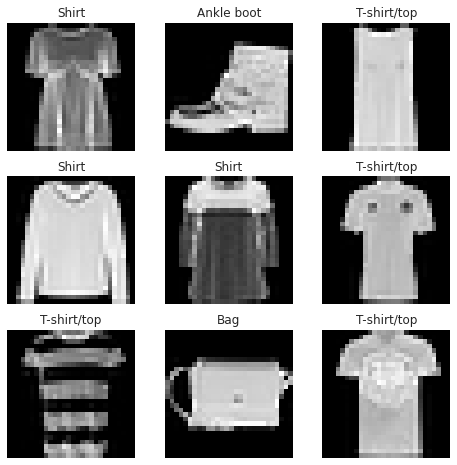

In [7]:
torch.manual_seed(0)

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

Архитектура модели взята из **[Introduction to PyTorch](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#define-the-class)**:

In [8]:
class FashionMNISTLogisticRegression(nn.Module):

    def __init__(self, in_features: int, out_features: int):
        super(FashionMNISTLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()  # по умолчанию разворачивает все измерения начиная со 2-ого
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, n_channels * width * height)
        return self.classifier(x)

In [6]:
def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)

        pred = model(x)  # (batch_size, n_classes)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

    return avg_loss / num_batches


def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:  # умеет работать с batch'ами; в нашем случае batch один
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy

Функция [потерь](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#loss-function) и [оптимизатор](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#optimizer) взяты из **Introduction to PyTorch**:

In [10]:
torch.manual_seed(0)

# количество входных параметров модели определяется как произведение:
# кол-во цветовых каналов * ширина картинки * высота картинки
net = FashionMNISTLogisticRegression(1 * 28 * 28, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_data, batch_size=64, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), num_workers=2)

net

FashionMNISTLogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

Обучаем модель:

In [11]:
%%time

epochs = 10
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

Epoch 1
--------------------------------
loss: 2.299407  [    0/60000]
loss: 2.245826  [ 6400/60000]
loss: 2.148032  [12800/60000]
loss: 2.109230  [19200/60000]
loss: 1.964170  [25600/60000]
loss: 1.873128  [32000/60000]
loss: 1.765596  [38400/60000]
loss: 1.640909  [44800/60000]
loss: 1.568382  [51200/60000]
loss: 1.412620  [57600/60000]
Test Error: 
 Accuracy: 0.639700, Avg loss: 1.403269 

Epoch 2
--------------------------------
loss: 1.437996  [    0/60000]
loss: 1.420322  [ 6400/60000]
loss: 1.167585  [12800/60000]
loss: 1.301452  [19200/60000]
loss: 1.074438  [25600/60000]
loss: 1.099373  [32000/60000]
loss: 1.062042  [38400/60000]
loss: 1.011352  [44800/60000]
loss: 1.048614  [51200/60000]
loss: 0.958107  [57600/60000]
Test Error: 
 Accuracy: 0.719900, Avg loss: 0.933654 

Epoch 3
--------------------------------
loss: 0.948851  [    0/60000]
loss: 1.005085  [ 6400/60000]
loss: 0.747223  [12800/60000]
loss: 0.985312  [19200/60000]
loss: 0.843050  [25600/60000]
loss: 0.860392  [

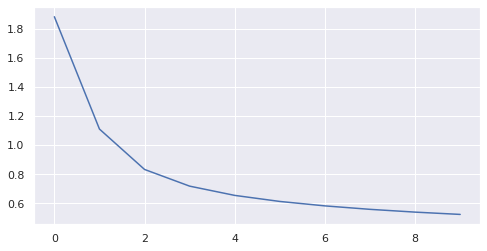

In [12]:
plt.plot(torch.arange(len(train_losses)), train_losses);

Пользуемся результатами обучения:

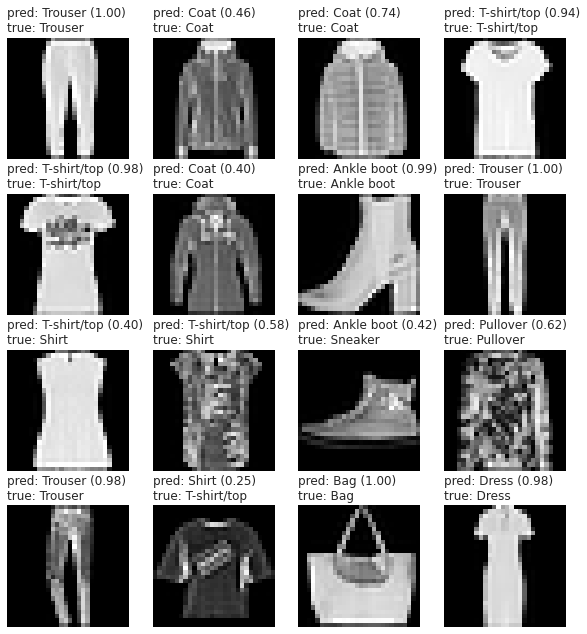

In [13]:
torch.manual_seed(0)
net.eval()

fig = plt.figure(figsize=(10, 11))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_data[sample_idx]
    img = img.to(DEVICE)

    pred = net(img.unsqueeze(0))
    pred_proba = F.softmax(pred, 1).max(1).values.item()  # насколько модель уверена в своем решении
    pred_label = pred.argmax(1).item()

    fig.add_subplot(rows, cols, i)
    plt.title(
        f"pred: {train_data.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {train_data.classes[true_label]}", loc="left"
    )
    plt.axis("off")
    plt.imshow(img.squeeze().cpu(), cmap="gray")

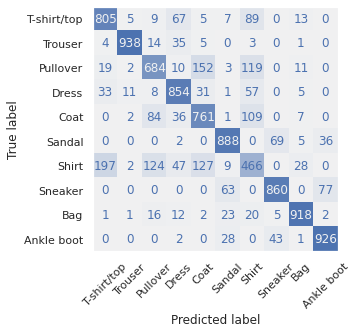

In [14]:
X_test, y_test = next(iter(test_dataloader))
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
pred_label = pred.argmax(dim=1)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.cpu(), pred_label.detach().cpu(),
    display_labels=train_data.classes,
    xticks_rotation=45,
    cmap=sns.color_palette("light:b", as_cmap=True),
    colorbar=False,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [15]:
test_loop(test_dataloader, net, loss_fn);

Test Error: 
 Accuracy: 0.810000, Avg loss: 0.538824 



Сохраняем модель:

In [16]:
torch.save(net, MODELS_DIR / "FashionMNIST-log-reg.pth")

FileNotFoundError: ignored

In [ ]:
net = torch.load(MODELS_DIR / "FashionMNIST-log-reg.pth")
net.eval()

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

Прежде чем работать дальше, ускорим загрузку данных:
- уберем ненужные преобразования (Tensor -> Image -> Tensor)
- сохраним преобразованный датасет
- сохраним результат работы Dataloader'а

In [7]:
class FastFashionMNSITDataset(Dataset):

    def __init__(self, dataset: datasets.FashionMNIST):
        self.dataset = dataset
        self.transform = self.dataset.transform

        self._data = self.dataset.data.to(torch.float32)
        if len(self._data.size()) == 3:  # [n_samples, width, height] -> [n_samples, n_channels, width, height]
            self._data = self._data.unsqueeze(1)

        self._targets = self.dataset.targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):  # избавимся от ненужных преобразований
        img, target = self._data[index], self._targets[index]
        if self.transform:
            img = self.transform(img)
        return img, target


class FastDataloader:

    def __init__(self, dataloader: DataLoader[Dataset], force: bool = False):
        self.dataloader = dataloader
        # кэш
        self._force = force
        self._bathes = [0] * len(self.dataloader)
        self._create_batches()

    @property
    def dataset(self):
        return self.dataloader.dataset

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        if self._force:
            self._create_batches()
        return self._get_iterator()

    def _create_batches(self):
        for i, batch in enumerate(self.dataloader):
            self._bathes[i] = batch

    def _get_iterator(self):
        for batch in self._bathes:
            yield batch

In [ ]:
_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
).data.to(torch.float32)

fast_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transforms.Compose([  # ToTensor() не нужно - уже Tensor
        transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
    ]),
)

slow_dataset = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
    ]),
)

In [ ]:
%%time

slow_dataloader = DataLoader(slow_dataset)

for epoch in range(50):
    for x, y in slow_dataloader:
        pass

In [ ]:
%%time

fast_dataset = FastFashionMNSITDataset(fast_data)
fast_dataloader = FastDataloader(fast_dataset)

for epoch in range(50):
    for x, y in fast_dataloader:
        pass

В 50 раз быстрее? А еще можно было сделать нормальное индексирование...

Архитектура модели (вдохновлялся `models.vgg16`):

In [ ]:
class FashionMNISTConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(FashionMNISTConvNet, self).__init__()
        self.features = nn.Sequential(OrderedDict({
            "conv1": nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            "norm1": nn.BatchNorm2d(32),
            "relu1": nn.ReLU(True),
            "maxpool1": nn.MaxPool2d(2),
            "conv2": nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            "norm2": nn.BatchNorm2d(64),
            "relu2": nn.ReLU(True),
            "maxpool2": nn.MaxPool2d(2),
        }))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # картинку произвольного размера -> 6 * 6
        self.classifier = nn.Sequential(OrderedDict({
            "fc1": nn.Linear(64 * 6 * 6, 512),
            "relu1": nn.ReLU(True),
            "drop1": nn.Dropout(),
            "fc2": nn.Linear(512, 128),
            "relu2": nn.ReLU(True),
            "drop2": nn.Dropout(),
            "fc3": nn.Linear(128, n_classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
).data.to(torch.float32)

transform = transforms.Compose([
    transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
])

fast_train_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

fast_test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

fast_train_dataset = FastFashionMNSITDataset(fast_train_data)
fast_test_dataset = FastFashionMNSITDataset(fast_test_data)

fast_train_dataloader = FastDataloader(DataLoader(fast_train_dataset, batch_size=128))
fast_test_dataloader = FastDataloader(DataLoader(fast_test_dataset, batch_size=len(fast_test_data)))

In [ ]:
torch.manual_seed(0)

net = FashionMNISTConvNet(1, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net

In [ ]:
%%time

epochs = 20
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(fast_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(fast_test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

In [ ]:
plt.plot(torch.arange(len(train_losses)), train_losses);

Визуализируем работу 1-ого сверточного слоя

In [ ]:
# входное изображение
img, target = fast_train_dataset[0]
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray");

In [ ]:
# изображения после свертки
first_conv_layer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
fig, axes = plt.subplots(6, 5, figsize=(5, 6))  # 6 * 5 = 30 != 32 - не покажу две картинки
for channel, ax in zip(first_conv_layer(img), axes.flatten()):
    ax.axis("off")
    ax.imshow(channel.detach(), cmap="gray")

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [17]:
_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
).data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

train_data.data.shape, len(train_data.targets), len(train_data.classes)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), 50000, 10)

In [18]:
fast_train_dataloader = FastDataloader(DataLoader(train_data, batch_size=128, num_workers=2))
fast_test_dataloader = FastDataloader(DataLoader(test_data, batch_size=len(test_data), num_workers=2))

Архитектура модели "Зачем что-то менять?" (авторское название)

In [19]:
class CIFAR10LogisticRegression(nn.Module):

    def __init__(self, in_features: int, out_features: int):
        super(CIFAR10LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.classifier(x)

In [ ]:
torch.manual_seed(0)

net = CIFAR10LogisticRegression(3 * 32 * 32, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

net

Обучаем модель:

In [ ]:
%%time

epochs = 15
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(fast_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(fast_test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

In [ ]:
plt.plot(torch.arange(len(train_losses)), train_losses);

In [ ]:
torch.manual_seed(0)
net.eval()

fig = plt.figure(figsize=(10, 11))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_data[sample_idx]

    pred = net(img.unsqueeze(0).to(DEVICE))
    pred_proba = F.softmax(pred, 1).max(1).values.item()
    pred_label = pred.argmax(1).item()

    fig.add_subplot(rows, cols, i)
    plt.title(
        f"pred: {train_data.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {train_data.classes[true_label]}", loc="left"
    )
    plt.axis("off")
    # 3 x 32 x 32 [-1, 1] -> 32 x 32 x 3 [0, 1]
    plt.imshow(torch.clip(img.permute(1, 2, 0), 0, 1).cpu())

In [ ]:
X_test, y_test = next(iter(fast_test_dataloader))
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
y_pred = pred.argmax(dim=1).detach()

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.cpu(), y_pred.cpu(),
    display_labels=train_data.classes,
    xticks_rotation=45,
    cmap=sns.color_palette("light:b", as_cmap=True),
    colorbar=False,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [ ]:
print(metrics.classification_report(y_test.cpu(), y_pred.cpu(), target_names=train_data.classes))

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

Архитектура модели "Зачем что-то менять? 2.0" (авторское название)

In [20]:
class CIFAR10ConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(CIFAR10ConvNet, self).__init__()
        self.features = nn.Sequential(OrderedDict({
            "conv1": nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            "norm1": nn.BatchNorm2d(32),
            "relu1": nn.ReLU(True),
            "maxpool1": nn.MaxPool2d(2),
            "conv2": nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            "norm2": nn.BatchNorm2d(64),
            "relu2": nn.ReLU(True),
            "maxpool2": nn.MaxPool2d(2),
        }))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(OrderedDict({
            "fc1": nn.Linear(64 * 6 * 6, 512),
            "relu1": nn.ReLU(True),
            "drop1": nn.Dropout(),
            "fc2": nn.Linear(512, 128),
            "relu2": nn.ReLU(True),
            "drop2": nn.Dropout(),
            "fc3": nn.Linear(128, n_classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [25]:
torch.manual_seed(0)

net = CIFAR10ConvNet(3, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net

CIFAR10ConvNet(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=2304, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (drop1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (relu2): ReLU(inplace=True)
    (drop2): Dropout(p=0.5, inplace=False)
    (fc3): Linear(in_fe

In [26]:
%%time

epochs = 20
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(fast_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(fast_test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

Epoch 1
--------------------------------
loss: 2.306680  [    0/50000]
loss: 1.567359  [12800/50000]
loss: 1.464912  [25600/50000]
loss: 1.370254  [38400/50000]
Test Error: 
 Accuracy: 0.557900, Avg loss: 1.218758 

Epoch 2
--------------------------------
loss: 1.315280  [    0/50000]
loss: 1.143047  [12800/50000]
loss: 1.238691  [25600/50000]
loss: 1.100901  [38400/50000]
Test Error: 
 Accuracy: 0.626800, Avg loss: 1.075289 

Epoch 3
--------------------------------
loss: 1.144582  [    0/50000]
loss: 1.224586  [12800/50000]
loss: 1.159860  [25600/50000]
loss: 1.103018  [38400/50000]
Test Error: 
 Accuracy: 0.646500, Avg loss: 1.006358 

Epoch 4
--------------------------------
loss: 0.968685  [    0/50000]
loss: 1.013891  [12800/50000]
loss: 1.057497  [25600/50000]
loss: 1.002020  [38400/50000]
Test Error: 
 Accuracy: 0.675400, Avg loss: 0.932042 

Epoch 5
--------------------------------
loss: 0.795158  [    0/50000]
loss: 0.941681  [12800/50000]
loss: 1.009756  [25600/50000]
loss:

In [28]:
X_test, y_test = next(iter(fast_test_dataloader))
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
y_pred = pred.argmax(dim=1).detach()

print(metrics.classification_report(y_test.cpu(), y_pred.cpu(), target_names=train_data.classes))

              precision    recall  f1-score   support

    airplane       0.83      0.80      0.82      1000
  automobile       0.88      0.89      0.89      1000
        bird       0.85      0.48      0.61      1000
         cat       0.58      0.57      0.58      1000
        deer       0.76      0.71      0.73      1000
         dog       0.61      0.76      0.68      1000
        frog       0.82      0.85      0.84      1000
       horse       0.72      0.85      0.78      1000
        ship       0.86      0.90      0.88      1000
       truck       0.84      0.87      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.76     10000



**Вывод:** не изменив ни одного параметра модели FashionMNSITConvNet я получил удовлетворительный результат для другой задачи. Однако, когда я решил с нуля собрать модель со своими (тоже случайными) параметрами, потратил время на подбор параметров (слои, каналы, ядра свертки, кол-во нейронов...) и гиперпараметров (оптимизатор, скорость обучения, размер батча), не смог приблизиться к 50% accuracy.

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [108]:
_data = datasets.ImageFolder(  # нужно для расчета mean и std для Normalize
    DATA_DIR / "monkeys/training/training",
    transform=transforms.Compose([
        transforms.CenterCrop(size=(224, 224)),
        transforms.ToTensor(),
    ]),
)
_data, _ = next(iter(DataLoader(_data, batch_size=len(_data))))

transform = transforms.Compose([
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(_data.mean(dim=(0, 2, 3)), _data.std(dim=(0, 2, 3))),
])

transform

Compose(
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4505, 0.4006, 0.3219]), std=tensor([0.2493, 0.2346, 0.2297]))
)

In [109]:
train_monkeys_dataset = datasets.ImageFolder(
    DATA_DIR / "monkeys/training/training",
    transform=transform,
)
test_monkeys_dataset = datasets.ImageFolder(
    DATA_DIR / "monkeys/validation/validation",
    transform=transform,
)

(
    (len(train_monkeys_dataset), len(test_monkeys_dataset)),
    train_monkeys_dataset[0][0].shape,
    len(train_monkeys_dataset.classes),
)

((1097, 272), torch.Size([3, 224, 224]), 10)

In [110]:
monkeys_labels: pd.DataFrame = pd.read_csv(DATA_DIR / "monkeys/monkey_labels.txt", sep=",")
monkeys_labels.columns = monkeys_labels.columns.map(str.strip)
strings_sample = monkeys_labels.select_dtypes(object)
monkeys_labels[strings_sample.columns] = strings_sample.applymap(str.strip)
monkeys_labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [122]:
class MonkeysConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(MonkeysConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((16, 16))
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [123]:
torch.manual_seed(0)

net = MonkeysConvNet(3, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

net

MonkeysConvNet(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=2304, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (drop1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (relu2): ReLU(inplace=True)
    (drop2): Dropout(p=0.5, inplace=False)
    (fc3): Linear(in_fe

In [124]:
monkeys_train_dataloader = FastDataloader(
    DataLoader(train_monkeys_dataset, batch_size=16, num_workers=2)
)
monkeys_test_dataloader = FastDataloader(
    DataLoader(test_monkeys_dataset, batch_size=len(test_monkeys_dataset), num_workers=2)
)

In [125]:
%%time

epochs = 30
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(monkeys_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(monkeys_test_dataloader, net, loss_fn)

Epoch 1
--------------------------------
loss: 2.247038  [    0/ 1097]
Test Error: 
 Accuracy: 0.095588, Avg loss: 2.306882 

Epoch 2
--------------------------------
loss: 2.424891  [    0/ 1097]
Test Error: 
 Accuracy: 0.154412, Avg loss: 2.298657 

Epoch 3
--------------------------------
loss: 2.353562  [    0/ 1097]



KeyboardInterrupt



In [ ]:
plt.plot(torch.arange(len(train_losses)), train_losses);

In [ ]:
torch.manual_seed(0)
net.eval()

fig = plt.figure(figsize=(10, 11))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_data[sample_idx]

    pred = net(img.unsqueeze(0).to(DEVICE))
    pred_proba = F.softmax(pred, 1).max(1).values.item()
    pred_label = pred.argmax(1).item()

    fig.add_subplot(rows, cols, i)
    plt.title(
        f"pred: {train_data.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {train_data.classes[true_label]}", loc="left"
    )
    plt.axis("off")
    # 3 x 32 x 32 [-1, 1] -> 32 x 32 x 3 [0, 1]
    plt.imshow(torch.clip(img.permute(1, 2, 0), 0, 1).cpu())

In [ ]:
X_test, y_test = next(iter(fast_test_dataloader))
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
y_pred = pred.argmax(dim=1).detach()

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.cpu(), y_pred.cpu(),
    display_labels=train_data.classes,
    xticks_rotation=45,
    cmap=sns.color_palette("light:b", as_cmap=True),
    colorbar=False,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [ ]:
print(metrics.classification_report(y_test.cpu(), y_pred.cpu(), target_names=train_data.classes))

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)